In [1]:
%pip install scipy
%pip install ipyparallel

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
from plot_toomre_q_projection import field_from_sliceplot
from smartstar_find import ss_properties
from plot_disc_projections import _make_disk_L
from plot_multi_projections import tidy_data_labels
from yt.utilities.math_utils import ortho_find
from plot_radial_profile_from_frb import extract_dd_segment, extract_simulation_name
from find_fourier_modes import get_theta_values, find_bar_radius, extract_dd_number
#from plot_density_slices_toomreq import find_fourier_modes_and_phase_angles
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yt

In [48]:
root_dir = [#"/ceph/cephfs/sgordon/cirrus-runs-rsync/seed2-bh-only/seed2-bh-only/270msun/replicating-beckmann-2/",
        #"/ceph/cephfs/sgordon/pleiades/seed2-bh-only/270msun/replicating-beckmann-2/2B.RSb08/"
        "/ceph/cephfs/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/"
        ]
sim = [#"2B.RSm04", 
    #"2B.m08-4dx"
    "1B.m16-4dx"
    #"2B.RSb08-2"
    ] 

dds = ["DD0167/DD0167", "DD0178/DD0178", "DD0189/DD0189", "DD0231/DD0231"]  # 0.39, 0.50, 0.6, 1 Myr for 1B.m16,
dds = ["DD0178/DD0178", "DD0189/DD0189", "DD0199/DD0199", "DD0225/DD0225"]  # 0.50, 0.60, 0.69, 0.94 Myr for 1B.m16,
#dds3 = ["DD0228/DD0228", "DD0268/DD0268", "DD0280/DD0280"]  # 0.3, 0.69, 0.79 Myr for 2B.m08-4dx, 
#dds = ["DD0219/DD0219", "DD0227/DD0227", "DD0236/DD0236", "DD0279/DD0279"]  # 0.2, 0.69, 1 Myr for 2B.b08,

# 1B.m16
dds_list = [["DD0178/DD0178", "DD0188/DD0188", "DD0199/DD0199", "DD0226/DD0226"],
            #["DD0178/DD0178", "DD0189/DD0189", "DD0199/DD0199", "DD0225/DD0225"],
            # ["DD0179/DD0179", "DD0186/DD0186", "DD0200/DD0200", "DD0228/DD0228"],
            # ["DD0177/DD0177", "DD0188/DD0188", "DD0197/DD0197", "DD0226/DD0226"],
            ]
# 1B.m16 for bar corotation radius
dds = [f"DD0{i:03d}/DD0{i:03d}" for i in range(190, 220)] # 0.6 - 0.9 Myr

#2B.b08
# dds_list = [#["DD0219/DD0219", "DD0227/DD0227", "DD0236/DD0236", "DD0276/DD0276"],
#             #["DD0218/DD0218", "DD0226/DD0226", "DD0235/DD0235", "DD0278/DD0278"],
#             #["DD0220/DD0220", "DD0228/DD0228", "DD0237/DD0237", "DD0279/DD0279"],
#             #["DD0217/DD0217", "DD0225/DD0225", "DD0234/DD0234", "DD0270/DD0270"],
#             ["DD0219/DD0219", "DD0246/DD0246", "DD0270/DD0270", "DD0279/DD0279"], # 0.29, 0.50, 0.70, 1 Myr
#             ]

In [49]:
# Load datasets
DS = []
for s in range(len(dds)):
    ds = yt.load(os.path.join(root_dir[0], sim[0], dds[s]))
    DS.append(ds)

yt : [INFO     ] 2023-11-09 13:03:14,013 Parameters: current_time              = 14.002701108193
yt : [INFO     ] 2023-11-09 13:03:14,015 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-11-09 13:03:14,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-09 13:03:14,017 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-11-09 13:03:14,018 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-09 13:03:14,019 Parameters: current_redshift          = 26.216953464539
yt : [INFO     ] 2023-11-09 13:03:14,020 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2023-11-09 13:03:14,021 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2023-11-09 13:03:14,022 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-11-09 13:03:14,024 Parameters: hubble_constant           = 0.71
yt : [INFO     ] 2023-11-09 13:03:14,127 Parameters: current_time              = 14.003818012193
yt :

In [6]:
def find_fourier_modes_and_phase_angles(radii, radius_pc, densities, theta, dV, dr=0.001, cylindrical_theta_velocity=None):
    """
    Compute the m=1, 2 Fourier mode strengths and phase angles for a given annular region of a disk.
    Input:
        radii: list of radii for annular regions
        radius_pc: 2D array of radii values for each cell in the disk
        densities: 2D array of densities values for each cell in the disk
        theta: 2D array of theta values for each cell in the disk
        dV: volume of each cell in the disk
        dr: thickness of annular regions
    Output:
        m1_strengths: list of m=1 Fourier mode strengths for each annular region
        m2_strengths: list of m=2 Fourier mode strengths for each annular region
        phi_1_values: list of m=1 Fourier mode phase angles for each annular region
        phi_2_values: list of m=2 Fourier mode phase angles for each annular region
    """
    m1_strengths = []
    m2_strengths = []
    phi_1_values = []
    phi_2_values = []
    angular_speeds = []
    for r in radii:
        # Define mask for annular region
        mask = (radius_pc >= r) & (radius_pc < r + dr)

        # Get densities and thetas for this annular region, where 0 < theta < 2pi - all same shape (713,)
        masked_densities = densities[mask]
        theta_2d = np.tile(theta, (densities.shape[0], 1))
        masked_theta = theta_2d[mask]
        if cylindrical_theta_velocity is not None:
            masked_theta_vel = cylindrical_theta_velocity[mask]
            angular_speed = masked_theta_vel / (r*yt.units.pc).to("cm")
            angular_speeds.append(angular_speed)

        # Compute the mass-equivalent for each cell in this region
        mass_equivalent = masked_densities * dV

        # Compute a and b coefficients for m=2 and m=1 modes
        a_2 = np.sum(mass_equivalent * np.cos(2 * masked_theta))
        b_2 = np.sum(mass_equivalent * np.sin(2 * masked_theta))
        a_1 = np.sum(mass_equivalent * np.cos(masked_theta))
        b_1 = np.sum(mass_equivalent * np.sin(masked_theta))

        # Compute A_0 for this region
        A_0 = np.sum(mass_equivalent)

        # Compute Fourier modes for this region
        A_2 = np.sqrt(a_2**2 + b_2**2)
        A_1 = np.sqrt(a_1**2 + b_1**2)

        # Normalise the Fourier mode strengths for this region
        m2_strength = A_2 / A_0 if A_0 != 0 else 0
        m1_strength = A_1 / A_0 if A_0 != 0 else 0
        m2_strengths.append(m2_strength)
        m1_strengths.append(m1_strength)

        # Compute the phase angle phi_2 for this region
        phi_2 = 0.5 * np.degrees(np.arctan2(b_2, a_2).value) # -90 < phi_2 < 90
        phi_1 = np.degrees(np.arctan2(b_1, a_1).value) # -180 < phi_1 < 180
        phi_2_values.append(phi_2)
        phi_1_values.append(phi_1)
    
    if cylindrical_theta_velocity is not None:
        return m1_strengths, m2_strengths, phi_1_values, phi_2_values, angular_speeds
    
    return m1_strengths, m2_strengths, phi_1_values, phi_2_values

In [14]:
def process_ds(ds, disc_r_pc, find_cylindrical_velocity=False):
    disc_r_pc = 0.1 # pc
    find_cylindrical_velocity = True
    # identify simulation name and label
    sim_label = tidy_data_labels(extract_simulation_name(ds.directory))
    print("Processing " + str(sim_label) + " " + str(extract_dd_segment(ds.directory)))

    # [Your code for setting up disk, radii, etc.]
    # Grab bh properties and define center, width and resolution of sliceplots
    ss_pos, ss_mass, ss_age = ss_properties(ds, velocity=False)
    center = ss_pos
    width_pc = 0.2
    npixels = 2048

    # Obtain angular momentum vector from small disk and define larger disk for plotting
    disc_h_pc = disc_r_pc
    _, L = _make_disk_L(ds, center, disc_r_pc, disc_h_pc)
    vecs = ortho_find(L)
    dir = vecs[0]
    north = vecs[1]
    disc_r_pc_big = disc_h_pc_big = 0.6 # pc
    disk = ds.disk(center, L, disc_r_pc_big, disc_h_pc_big)

    # Obtain density and radius values for each cell in the disk
    density, radius_pc = field_from_sliceplot("density", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=True)
    dx = ds.index.get_smallest_dx().in_units('pc')
    surface_density = density * dx # g/cm^2

    # List of radii to define annular regions with thickness dr
    dr = 0.001 # pc
    dx = ds.index.get_smallest_dx().in_units('pc').d
    dx = 0.0008
    r_max_pc = 0.14 # pc 
    r_min = dx
    r_max = r_max_pc
    radii = np.arange(r_min, r_max + dr, dr)  # 141 annuli (fixed at this number)

    # Compute theta values of each annulus
    dV = dx**3
    theta = get_theta_values(surface_density)
    cylindrical_velocity_theta, radius_pc_theta = field_from_sliceplot("velocity_cylindrical_theta", ds, disk, center, width_pc, north, dir, npixels=npixels, radius=True)

    # Compute Fourier modes and phase angles in degrees (not radians), and store them
    _, _, _, phi_2_values, angular_speeds = find_fourier_modes_and_phase_angles(radii, radius_pc, density, theta, dV, dr, cylindrical_velocity_theta)

        
    if find_cylindrical_velocity:
        return phi_2_values, ss_age/1e6, radii, angular_speeds

    return phi_2_values, ss_age/1e6, radii

In [29]:
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}. host={MPI.Get_processor_name()}"

# request an MPI cluster with 24 engines
with ipp.Cluster(controller_ip="*", engines="mpi", n=2) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    results = view.apply_sync(mpi_example)
    # Retrieve and print the result from the engines
    rc.wait_interactive()
    
    print("\n".join(r))
# at this point, the cluster processes have been shutdown

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

Hello World from rank 0. total ranks=2. host=cuillin
Hello World from rank 1. total ranks=2. host=cuillin
Stopping engine(s): 1699532545
engine set stopped 1699532545: {'exit_code': 1, 'pid': 341446, 'identifier': 'ipengine-1699532543-1im5-1699532545-249976'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 340510, 'identifier': 'ipcontroller-1699532543-1im5-249976'}


In [26]:
# This works!!!
import ipyparallel as ipp

def process_dataset(root_dir, sim, dd, disc_r_pc=0.1):
    """
    Process a single dataset.
    """
    # Import packages
    import yt
    import os
    from find_corotation_radius import process_ds

    # Load dataset
    ds = yt.load(os.path.join(root_dir, sim, dd))

    # Process dataset
    phi_2_value, current_age, radiuses, angular_speed = process_ds(ds, disc_r_pc, find_cylindrical_velocity=True)

    # Return results
    return phi_2_value, current_age, radiuses, angular_speed


def run_parallel_analysis(root_dir, sim, dds, n_cores=2):
    """
    Run analysis in parallel using IPyParallel.
    """
    with ipp.Cluster(n=n_cores) as rc:  # Adjust 'n' based on the number of engines you want
        view = rc.load_balanced_view()

        # Use map_sync to distribute the processing of datasets across the engines
        results = view.map_sync(process_dataset, [root_dir]*len(dds), [sim]*len(dds), dds)

    # Process results
    phi_2_values, ages, radii, angular_speeds = zip(*results)
    return list(phi_2_values), list(ages), list(radii), list(angular_speeds)


# Usage
root_dir = "/ceph/cephfs/sgordon/pleiades/seed1-bh-only/270msun/replicating-beckmann/"
sim = "1B.m16-4dx"
dds = [f"DD0{i:03d}/DD0{i:03d}" for i in range(130, 140)]
n_cores = 5

phi_2_values, ages, radii, angular_speeds = run_parallel_analysis(root_dir, sim, dds, n_cores)


Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

In [ ]:
all_phi_2_values = phi_2_values
all_ages = ages
all_angular_speeds = angular_speeds
all_radii = radii

# Define all variables after MPI gather
phi_2_values_array = [np.array(phi) for phi in all_phi_2_values] # list of arrays
ages_array = np.array([age[0] for age in all_ages]) # list of floats
angular_speed_means = [[np.mean(annulus) for annulus in dataset] for dataset in angular_speeds]

#  Compute the difference between phi2 values at each snapshot
delta_phi = np.array([phi_2_values_array[i] - phi_2_values_array[i+1] for i in range(len(phi_2_values_array)-1)])
delta_t = np.array(np.diff(ages_array))
pattern_speeds = delta_phi / delta_t[:, np.newaxis]
conversion_factor = np.pi / (180 * 3.154e13)
pattern_speeds_radians_per_sec = pattern_speeds * conversion_factor


/home/sgordon/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/sgordon/.local/lib/python3.10/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Saved plot to corotation_radius/angular_and_pattern_speed_vs_radius_0.11_0.21.png


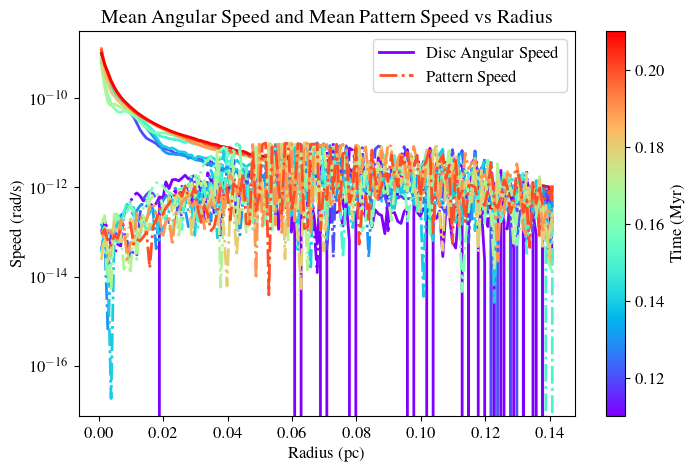

In [ ]:

fig, ax = plt.subplots(figsize=(8, 5))
n = len(angular_speed_means)
# Choose a colormap
cmap = plt.cm.rainbow
# Create color list
colors = [cmap(i) for i in np.linspace(0, 1, n)]
scalars = np.linspace(all_ages[0][0], all_ages[-1][0], n)
norm = plt.Normalize(min(scalars), max(scalars))
# Create a ScalarMappable and set array to the normalized values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for j in range(len(angular_speed_means)):
    ax.plot(all_radii[j], angular_speed_means[j], label="Disc Angular Speed", linestyle="-", color=cmap(norm(scalars[j])))
for i in range(len(pattern_speeds)):
    ax.plot(all_radii[i+1], abs(pattern_speeds_radians_per_sec)[i], label="Pattern Speed", linestyle="dashdot", color=cmap(norm(scalars[i])))
plt.colorbar(sm, ax=ax, label='Time (Myr)')
handles, labels = ax.get_legend_handles_labels()
# Assuming you want to include only the first two
legend_handle_1 = handles[0]
legend_handle_2 = handles[-1]
plt.legend(handles=[legend_handle_1, legend_handle_2], labels=[labels[0], labels[-1]])
plt.yscale("log")
#plt.xscale("log")    
plt.xlabel("Radius (pc)")
plt.ylabel("Speed (rad/s)")
plt.title("Mean Angular Speed and Mean Pattern Speed vs Radius")
plt.savefig(f"corotation_radius/angular_and_pattern_speed_vs_radius_{all_ages[0][0]:.2f}_{all_ages[-1][0]:.2f}.png", bbox_inches="tight")
print(f"Saved plot to corotation_radius/angular_and_pattern_speed_vs_radius_{all_ages[0][0]:.2f}_{all_ages[-1][0]:.2f}.png")
plt.show()

In [24]:
handles[0].set_color('grey')